# Process Ocean U/V with "RotatedAngle_ANHA4.nc"

This is the notebook that shows how to correct ANHA4 ocean u/v by `RotatedAngle_ANHA4.nc` .

In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [2]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

/home/yingkai/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
import cartopy
#import cartopy.crs as ccrs

In [4]:
sb.set_style('white')

In [5]:
def interp_np(xin, yin, zin, xout, yout):
    zout = Nts.reporj_NEMOgrid(xin, yin, zin, xout, yout, method='linear')
    zfill = Nts.reporj_NEMOgrid(xin, yin, zin, xout, yout, method='nearest')
    zout[np.isnan(zout)] = zfill[np.isnan(zout)]
    #zout[yout>89.99] = np.nan
    return zout

In [6]:
ocean_x = np.linspace(-180, 180, 140)
ocean_y = np.linspace(20, 90, 140)
ocean_lon, ocean_lat = np.meshgrid(ocean_x, ocean_y)

In [7]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

In [8]:
ra_obj = nc.Dataset('../../_data/Exchange/RotatedAngle_ANHA4.nc')
gsint = ra_obj.variables['gsint'][:]
gcost = ra_obj.variables['gcost'][:]

# Ocean U/V

In [9]:
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current.mat')
u0 = MAT['vozocrtx0'][0, :, :]
v0 = MAT['vomecrty0'][0, :, :]

In [10]:
u1 = np.copy(u0); u1[:, 1:] = 0.5*(u0[:, 0:-1] + u0[:, 1:])
v1 = np.copy(v0); v1[1:, :] = 0.5*(v0[0:-1, :] + v0[1:, :])
u_rot = u1*gcost - v1*gsint
v_rot = v1*gcost + u1*gsint

In [125]:
u_regrid = interp_np(nav_lon, nav_lat, u_rot, ocean_lon, ocean_lat)
v_regrid = interp_np(nav_lon, nav_lat, v_rot, ocean_lon, ocean_lat)

In [126]:
u_wrong = interp_np(nav_lon, nav_lat, u0, ocean_lon, ocean_lat)
v_wrong = interp_np(nav_lon, nav_lat, v0, ocean_lon, ocean_lat)

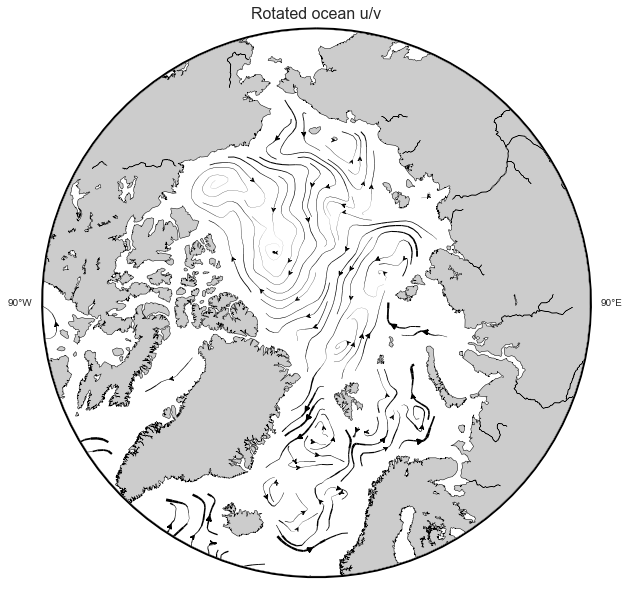

In [237]:
fig = plt.figure(figsize=(10, 10))

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.49
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax_background = fig.gca()
patch = patches.PathPatch(circle, lw=4)
ax_background.add_patch(patch)
ax_background.axis('off')

ax_proj = fig.gca(projection=cartopy.crs.NorthPolarStereo(0))
ax_proj.set_extent([-180, 180, 60, 90], cartopy.crs.PlateCarree())
ax_proj.set_boundary(circle, transform=ax_proj.transAxes)

proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=False, ax=ax_proj)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
proj.drawmeridians(np.array([-90, 90]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)

uproj, vproj = proj.rotate_vector(u_regrid, v_regrid, ocean_lon, ocean_lat, returnxy=False)
uproj_rec, x, y = proj.transform_scalar(uproj, ocean_x, ocean_y, 150, 150, returnxy=True)
vproj_rec, _, _ = proj.transform_scalar(vproj, ocean_x, ocean_y, 150, 150, returnxy=True)

speed = np.sqrt(uproj_rec**2 + vproj_rec**2)
lw = 10*speed/np.nanmax(speed)

proj.streamplot(x, y, uproj_rec, vproj_rec, density=3, linewidth=lw, color='k', arrowstyle='fancy', arrowsize=1.0)

ax_background.set_title('Rotated ocean u/v', fontsize=16)

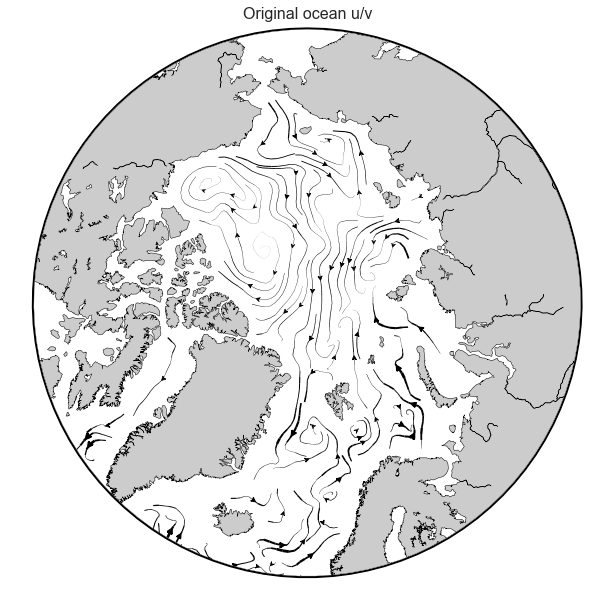

In [230]:
fig = plt.figure(figsize=(10, 10))

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.49
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax_background = fig.gca()
patch = patches.PathPatch(circle, lw=4)
ax_background.add_patch(patch)
ax_background.axis('off')

ax_proj = fig.gca(projection=cartopy.crs.NorthPolarStereo(0))
ax_proj.set_extent([-180, 180, 60, 90], cartopy.crs.PlateCarree())
ax_proj.set_boundary(circle, transform=ax_proj.transAxes)

proj = Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=False, ax=ax_proj)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')

uproj_rec, x, y = proj.transform_scalar(u_wrong, ocean_x, ocean_y, 150, 150, returnxy=True)
vproj_rec, _, _ = proj.transform_scalar(v_wrong, ocean_x, ocean_y, 150, 150, returnxy=True)

speed = np.sqrt(uproj_rec**2 + vproj_rec**2)
lw = 10*speed/np.nanmax(speed)

proj.streamplot(x, y, uproj_rec, vproj_rec, density=3, linewidth=lw, color='k', arrowstyle='fancy', arrowsize=1.0)

ax_background.set_title('Original ocean u/v', fontsize=16)

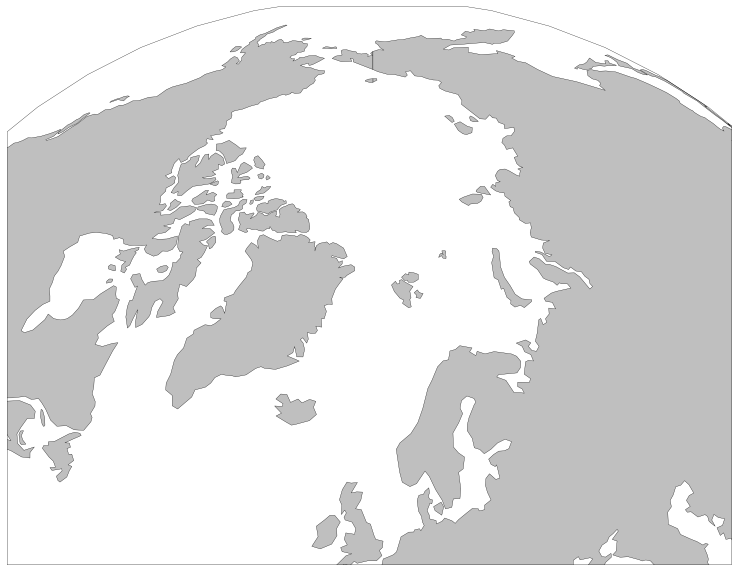

In [190]:
fig = plt.figure(figsize=(14, 10))
ax = fig.gca(projection=cartopy.crs.Orthographic(0, 50))

ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black', facecolor='0.75')
ax.set_extent([-180, 180, 50, 90], cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)

fig.savefig('Sketch_background.eps', dpi=300, orientation='portrait', papertype='a4', format='eps',
                bbox_inches='tight', pad_inches=0.1)